# Analyzing Stock Market Sentiment Through Twitter Data

# Jalendar Reddy Maligireddy

# Importing Required packages

In [1]:
import tweepy
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



# API credentials

In [2]:

# Your API credentials
consumer_key= 'Your_key'
consumer_secret= 'Your_key'
access_token= 'Your_key'
access_token_secret= 'Your_key'


In [3]:

# Authenticate API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)


authenticates the user's access to Twitter's API using their consumer key, consumer secret, access token, and access token secret. Once authenticated, it initializes a Tweepy API object with the authentication credentials, allowing the user to make authorized requests to the Twitter API. The wait_on_rate_limit parameter specifies whether or not the API should automatically wait for rate limits to expire before making further requests, which helps to avoid being rate limited by the Twitter API.

In [4]:

# Collect tweets
keywords = ['yahoofinance and tesla', 'tesla', 'TSLA']
limit = 1000

tweets_text = []

for keyword in keywords:
    tweets = tweepy.Cursor(api.search_tweets, q=keyword, tweet_mode='extended').items(limit)
    for tweet in tweets:
        tweets_text.append(tweet.full_text)


Rate limit reached. Sleeping for: 212


By using the Tweepy library to authenticate API credentials and collect tweets containing specific keywords. The keywords are 'yahoofinance and tesla', 'tesla', and 'TSLA'. It collects up to 1000 tweets for each keyword, by using the tweepy.Cursor() method to iterate over search results pages returned by the Twitter API. For each tweet found, it extracts the full text of the tweet and appends it to a list called 
tweets_text.

In [5]:
tweets_text

['RT @ihors3: I enjoyed talking #Tesla on Yahoo Finance this morning with Julie and Brad. $TSLA @S3Partners @elonmusk @YahooFinance  https://…',
 'RT @SPGlobalRatings: Discussing Tesla earnings expectations, EVs’ price cuts and their market outlook, Nishit Madlani, Autos Senior Directo…',
 'RT @ihors3: I enjoyed talking #Tesla on Yahoo Finance this morning with Julie and Brad. $TSLA @S3Partners @elonmusk @YahooFinance  https://…',
 'I enjoyed talking #Tesla on Yahoo Finance this morning with Julie and Brad. $TSLA @S3Partners @elonmusk @YahooFinance  https://t.co/jSbis1AWvX',
 "@YahooFinance @business Maybe prices are dropping because people cancelled their Tesla purchase because they don't want to drive around wearing a MAGA hat and Trump 2024 bumper stickers.\n\n@elonmusk chose his buyers by going there. FACT.",
 "RT @YahooFinance: Tesla stock sinks as Wall Street searches for 'gross margin' floor https://t.co/bl6G6c9TeV by @_JoshSchafer and @Pras_S $…",
 'RT @SPGlobalRatings: Discuss

In [6]:

# Preprocess tweets
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stopword = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

processed_tweets = []

for tweet in tweets_text:
    content = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    tokens = word_tokenize(content)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopword and len(token) > 1]
    processed_tweets.append(' '.join(tokens))




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NLTK library to preprocess the collected tweets. It downloads necessary NLTK resources, removes stopwords and non-alphanumeric characters, tokenizes each tweet into words, lemmatizes each word, and creates a new list of processed tweets.

In [7]:
# Remove duplicate and single-word sentences
processed_tweets = list(set(processed_tweets))
processed_tweets = [tweet for tweet in processed_tweets if len(tweet) > 10]


first removes duplicate entries from the 
processed_tweets
 list using 
set()
 and then converts it back to a list. It then removes sentences which have less than or equal to 10 characters (single-word sentences) using a list comprehension.

In [8]:
# Save preprocessed tweets to a CSV file
pd.DataFrame(processed_tweets, columns=['Cleaned_Text']).to_csv('preprocessed_tweets.csv', index=False)


the preprocessed tweets, which are stored in the 
processed_tweets
 list, to a CSV file named "preprocessed_tweets.csv". The tweets are saved in a single column called 'Cleaned_Text' and the index is not included in the saved file. The 
pd.DataFrame()
 function is used to convert the list of tweets into a Pandas DataFrame object before saving it as a CSV file.

In [9]:
processed_tweets=pd.read_csv("preprocessed_tweets.csv")

In [38]:
processed_tweets.shape

(1207, 1)

In [10]:
processed_tweets.head(5)

,Cleaned_Text
0,Charging Tesla minding business Lambo decides ...
1,RT Tesla real time order data could shed light...
2,Do believe written origin tesla fool
3,From StockheadComAu Market Highlights Tesla cr...
4,This crazy Tesla Model 40 000 Model 37 000 via


In [11]:
# Load datasets
df_all_data = pd.read_csv("all-data.csv", encoding='latin-1', sep=',', header=None, names=['Sentiment', 'Text'])
stock_twitter_df = pd.read_csv("stock_twitter.csv", encoding='latin-1', sep=',')



loads two datasets from CSV files into pandas dataframes: "all-data.csv" with columns 'Sentiment' and 'Text', and "stock_twitter.csv". The encoding of both files is "latin-1" and the separator is a comma (',').

In [39]:
df_all_data.shape

(4847, 2)

In [12]:
df_all_data.head(5)

,Sentiment,Text
0,Sentiment,Text
1,neutral,"According to Gran , the company has no plans t..."
2,neutral,Technopolis plans to develop in stages an area...
3,negative,The international electronic industry company ...
4,positive,With the new production plant the company woul...


In [40]:
stock_twitter_df.shape

(5791, 2)

In [13]:
stock_twitter_df.head(5)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,positive
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,positive
2,user I'd be afraid to short AMZN - they are lo...,positive
3,MNTA Over positive2.00,positive
4,OI Over 2positive.37,positive


In [14]:
# Combine datasets
all_data_df = pd.concat([df_all_data, stock_twitter_df])


combines two pandas DataFrames, 
all_data_df
 and 
stock_twitter_df
, by concatenating them vertically. The resulting DataFrame has all the rows from both DataFrames.

In [15]:
all_data_df.head(5)

,Sentiment,Text
0,Sentiment,Text
1,neutral,"According to Gran , the company has no plans t..."
2,neutral,Technopolis plans to develop in stages an area...
3,negative,The international electronic industry company ...
4,positive,With the new production plant the company woul...


In [41]:
all_data_df.shape

10638

In [42]:
df_all_data.shape[0] + stock_twitter_df.shape[0]

10638

Checking all_data_df have all rows from both dataframes

In [16]:
# Clean the train data by removing stop words and performing lemmatization
stopword = set(stopwords.words('english'))
Cleaned_data = []
for x in all_data_df['Text']:
    tokens = word_tokenize(str(x))
    final_tokens = [w for w in tokens if w not in stopword]
    wordLemm = WordNetLemmatizer()
    finalwords = []
    for w in final_tokens:
        if len(w) > 1:
            word = wordLemm.lemmatize(w)
            finalwords.append(word)
    Cleaned_data.append(' '.join(finalwords))
all_data_df['Cleaned_Text'] = Cleaned_data


loads two datasets (
all-data.csv
 and 
stock_twitter.csv
) using pandas read_csv() function. 
all-data.csv
 dataset contains two columns: 'Sentiment' and 'Text', while 
stock_twitter.csv
 has several columns including 'Text', which contains the tweets related to stocks.

Then, it concatenates both datasets using pd.concat() function into one dataframe called all_data_df.

After that, the code preprocesses the text data in the 'Text' column of the concatenated dataframe by removing stopwords and performing lemmatization. It then adds this preprocessed text as a new column to the same dataframe called 'Cleaned_Text'.

In [17]:
# Filter out classes with fewer than 2 samples
class_counts = all_data_df['Sentiment'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
filtered_df = all_data_df[all_data_df['Sentiment'].isin(valid_classes)]


 filters out the classes with fewer than 2 samples from the dataset. It counts the number of samples for each sentiment class in the 'Sentiment' column of 'all_data_df', and stores them in 'class_counts'.
Then, it selects only those classes that have two or more samples and stores them in 'valid_classes'. Next, it creates a new DataFrame called 'filtered_df', which includes only the rows from 'all_data_df' where the 'Sentiment' column value is in 'valid_classes'.

In [18]:
# Split the data into train and test sets
Train_X, Test_X, Train_Y, Test_Y = train_test_split(filtered_df['Cleaned_Text'], filtered_df['Sentiment'], test_size=0.3, random_state=25, stratify=filtered_df['Sentiment'])


splits the filtered data into two sets, a training set (Train_X and Train_Y) and a test set (Test_X and Test_Y). The splitting is done using the train_test_split function from the scikit-learn library. The size of the test set is set to 30% of the total data, with a random_state set to 25 for reproducibility. The stratify argument ensures that the distribution of classes in the original data is maintained in both the training and test sets.

In [19]:
Train_X.shape

(7445,)

In [20]:
Train_Y.shape

(7445,)

In [21]:
Test_Y.shape

(3192,)

In [22]:
Test_X.shape

(3192,)

# Multinomial Naive Bayes classifier

In [23]:
# Create a pipeline with the Tf-IDF vector and Multinomial Naive Bayes classifier
model = make_pipeline(TfidfVectorizer(), MultinomialNB())


creates a pipeline that consists of two steps:

TfidfVectorizer()
 - a feature extraction method that converts text documents to a matrix of TF-IDF features.

MultinomialNB()
 - a probabilistic classifier based on the Bayes theorem that uses the Naive assumption that the features are conditionally independent given the class.

The pipeline enables the model to apply both the feature extraction and classification steps together in one step for efficiency.

In [24]:
# Train the model using the fit method
model.fit(Train_X, Train_Y)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

creates a machine learning model pipeline with the 
TfidfVectorizer()
 and 
MultinomialNB()
 estimator. Then, the model is trained on the training data (
Train_X
 and 
Train_Y
) using the 
fit()
 method. The 
TfidfVectorizer()
 creates a sparse matrix of term frequency-inverse document frequency (TF-IDF) features from the text data, while 
MultinomialNB()
 is a probabilistic classifier based on the Bayes theorem that is used to predict the sentiment class labels.

In [25]:
# Load the preprocessed tweets and predict the sentiment
preprocessed_tweets_df = pd.read_csv("preprocessed_tweets.csv")
preprocessed_tweets = preprocessed_tweets_df['Cleaned_Text']
predicted_labels = model.predict(preprocessed_tweets)


 loads preprocessed tweets from a CSV file, applies the trained model to predict the sentiment of each tweet, and stores the predicted labels in a NumPy array called 
predicted_labels
. The 
preprocessed_tweets
 variable holds the cleaned version of the tweets.

In [26]:
# Write the predicted labels to a CSV file
preprocessed_tweets_df['Sentiment'] = predicted_labels
preprocessed_tweets_df.to_csv('predicted_tweets_nbc.csv', index=False)



loads the preprocessed tweets from a CSV file, predicts their sentiment using a trained model and saves the predicted labels to another CSV file. Specifically, it first reads the 'Cleaned_Text' column from the preprocessed_tweets.csv file into a pandas DataFrame. Then, it uses the trained model to predict the sentiment of each tweet and stores the predicted labels in a new column named 'Sentiment'. Finally, it writes the entire DataFrame, including the predicted labels, to a new CSV file named 'predicted_tweets_nbc.csv'.

In [27]:
nbc_processed_tweets=pd.read_csv('predicted_tweets_nbc.csv')
nbc_processed_tweets.head(5)

,Cleaned_Text,Sentiment
0,Charging Tesla minding business Lambo decides ...,positive
1,RT Tesla real time order data could shed light...,positive
2,Do believe written origin tesla fool,positive
3,From StockheadComAu Market Highlights Tesla cr...,positive
4,This crazy Tesla Model 40 000 Model 37 000 via,positive


#### Multinomial Naive Bayes classifier
#### Result

In [28]:
from sklearn.metrics import classification_report, accuracy_score
Test_Y_pred = model.predict(Test_X)
accuracy = accuracy_score(Test_Y, Test_Y_pred)
print(f'Accuracy: {accuracy:.2f}')
report = classification_report(Test_Y, Test_Y_pred, output_dict=True)

for sentiment, scores in report.items():
    if sentiment != 'accuracy' and sentiment != 'macro avg' and sentiment != 'weighted avg':
        print()
        print(f"Sentiment: {sentiment}")
        print(f"Precision: {scores['precision']:.2f}")
        print(f"Recall: {scores['recall']:.2f}")
        print(f"F1-score: {scores['f1-score']:.2f}")
        print(f"Support: {scores['support']:.2f}")      
        print()


Accuracy: 0.67

Sentiment: negative
Precision: 0.86
Recall: 0.20
F1-score: 0.32
Support: 813.00


Sentiment: neutral
Precision: 0.74
Recall: 0.78
F1-score: 0.76
Support: 864.00


Sentiment: positive
Precision: 0.63
Recall: 0.87
F1-score: 0.73
Support: 1515.00



classification metrics on the test set using the trained model. It predicts labels for the test set and computes accuracy, precision, recall, F1-score, and support for each sentiment class. The results are printed in a formatted output.

##### Plot

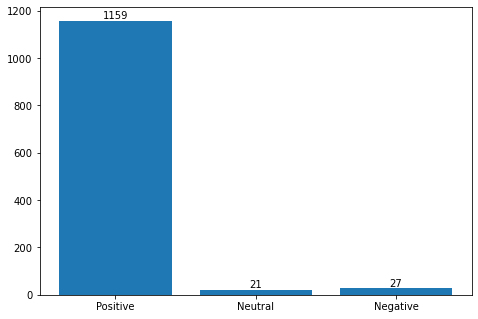

In [29]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

positive_count = (predicted_labels == "positive").sum()
neutral_count = (predicted_labels == "neutral").sum()
negative_count = (predicted_labels == "negative").sum()

# Use integer counts instead of string labels for x-axis ticks
Sentiment = [0, 1, 2]
Count = [positive_count, neutral_count, negative_count]

# Set the x-axis ticks and tick labels
ax.set_xticks(Sentiment)
ax.set_xticklabels(['Positive', 'Neutral', 'Negative'])

# Plot the bars
ax.bar(Sentiment, Count)

# Add the label values above each bar
for i, v in enumerate(Count):
    ax.text(i, v, str(v), color='black', ha='center', va='bottom')

plt.show()


creates a bar chart using the predicted sentiment labels. It counts the number of positive, neutral, and negative sentiments from the predicted labels and plots them on the y-axis. The x-axis has three labels for Positive, Neutral, and Negative. Finally, it adds the label values above each bar to indicate the count of predicted sentiments for each category.

#### Confusion Matrix and Plot

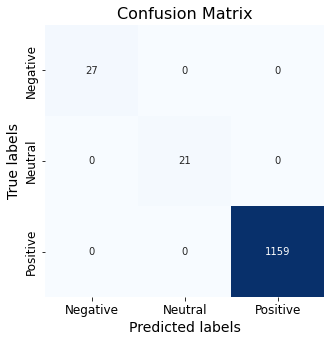

In [30]:

# Get the confusion matrix
cm = confusion_matrix(preprocessed_tweets_df['Sentiment'], predicted_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', cbar=False, ax=ax)

# Set the tick labels for the x-axis and y-axis
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=12)
ax.set_yticklabels(['Negative', 'Neutral', 'Positive'], fontsize=12)

# Set the axis labels
ax.set_xlabel("Predicted labels", fontsize=14)
ax.set_ylabel("True labels", fontsize=14)

# Set the title
ax.set_title("Confusion Matrix", fontsize=16)

plt.show()


creates a confusion matrix using the predicted sentiment labels and the actual sentiment labels of the preprocessed tweets. Firstly, it calculates the confusion matrix using 
confusion_matrix()
 function from sklearn.metrics module. Then, it plots the confusion matrix using seaborn's heatmap plot. The diagonal of the matrix represents the number of correct predictions for each class, while off-diagonal elements represent the number of misclassifications. It also sets the tick labels for x-axis and y-axis, axis labels, and title for the plot.

# Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
# Create a pipeline with the Tf-IDF vector and Random Forest classifier
model_rfc = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100, random_state=25))

# Train the model using the fit method
model_rfc.fit(Train_X, Train_Y)

# Load the preprocessed tweets and predict the sentiment
preprocessed_tweets_df = pd.read_csv("preprocessed_tweets.csv")
preprocessed_tweets = preprocessed_tweets_df['Cleaned_Text']
predicted_labels = model_rfc.predict(preprocessed_tweets)

# Write the predicted labels to a CSV file
preprocessed_tweets_df['Sentiment'] = predicted_labels
preprocessed_tweets_df.to_csv('predicted_tweets_rfc.csv', index=False)


creates a pipeline with TfidfVectorizer and RandomForestClassifier, trains the model on Train_X and Train_Y data, loads preprocessed tweets from the CSV file "preprocessed_tweets.csv", predicts the sentiment using the trained model, writes the predicted labels to a CSV file "predicted_tweets_rfc.csv".

In [33]:
rfc_processed_tweets=pd.read_csv('predicted_tweets_rfc.csv')
rfc_processed_tweets.head(5)

,Cleaned_Text,Sentiment
0,Charging Tesla minding business Lambo decides ...,neutral
1,RT Tesla real time order data could shed light...,positive
2,Do believe written origin tesla fool,positive
3,From StockheadComAu Market Highlights Tesla cr...,positive
4,This crazy Tesla Model 40 000 Model 37 000 via,positive


#### Random Forest Classifier
#### Results

In [34]:

from sklearn.metrics import classification_report, accuracy_score
Test_Y_pred = model_rfc.predict(Test_X)
accuracy = accuracy_score(Test_Y, Test_Y_pred)
print(f'Accuracy: {accuracy:.2f}')
report = classification_report(Test_Y, Test_Y_pred, output_dict=True)
for sentiment, scores in report.items():
    if sentiment != 'accuracy' and sentiment != 'macro avg' and sentiment != 'weighted avg':
        print()
        print(f"Sentiment: {sentiment}")
        print(f"Precision: {scores['precision']:.2f}")
        print(f"Recall: {scores['recall']:.2f}")
        print(f"F1-score: {scores['f1-score']:.2f}")
        print(f"Support: {scores['support']:.2f}")      
        print()


Accuracy: 0.71

Sentiment: negative
Precision: 0.73
Recall: 0.52
F1-score: 0.61
Support: 813.00


Sentiment: neutral
Precision: 0.68
Recall: 0.83
F1-score: 0.75
Support: 864.00


Sentiment: positive
Precision: 0.72
Recall: 0.75
F1-score: 0.74
Support: 1515.00



evaluates the performance of a Random Forest Classifier model on a test set. It uses the 
classification_report()
 function and 
accuracy_score()
 function from 
sklearn.metrics
 module to calculate and print precision, recall, F1-score, support and accuracy of the classifier for each sentiment class in the test set. The output is a series of printed statements that report the performance of the Random Forest Classifier model on the test data.

#### Plot

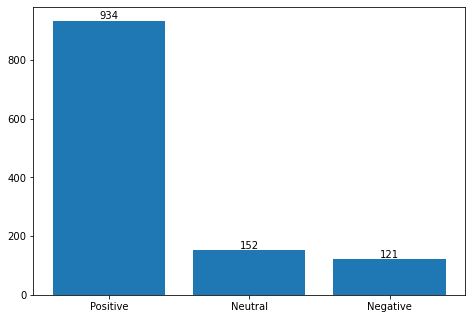

In [35]:

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

positive_count = (predicted_labels == "positive").sum()
neutral_count = (predicted_labels == "neutral").sum()
negative_count = (predicted_labels == "negative").sum()

# Use integer counts instead of string labels for x-axis ticks
Sentiment = [0, 1, 2]
Count = [positive_count, neutral_count, negative_count]

# Set the x-axis ticks and tick labels
ax.set_xticks(Sentiment)
ax.set_xticklabels(['Positive', 'Neutral', 'Negative'])

# Plot the bars
ax.bar(Sentiment, Count)

# Add the label values above each bar
for i, v in enumerate(Count):
    ax.text(i, v, str(v), color='black', ha='center', va='bottom')

plt.show()



creates a horizontal bar chart to display the distribution of sentiment labels in the predicted labels generated by a Random Forest classifier.

fig = plt.figure()
 creates a new figure object.


ax = fig.add_axes([0, 0, 1, 1])
 adds an axes object to the figure.


positive_count
, 
neutral_count
, and 
negative_count
 are calculated as the number of tweets with each respective sentiment label in the predicted labels.


Sentiment = [0, 1, 2]
 and 
Count = [positive_count, neutral_count, negative_count]
 set up the x-axis and y-axis values for the plot.


ax.set_xticks(Sentiment)
 and 
ax.set_xticklabels(['Positive', 'Neutral', 'Negative'])
 set the x-axis ticks and tick labels.


ax.bar(Sentiment, Count)
 plots the bars.
ax.text(i, v, str(v), color='black', ha='center', va='bottom')
 adds the count values above each bar.

 
plt.show()
 displays the plot.

# confusion matrix

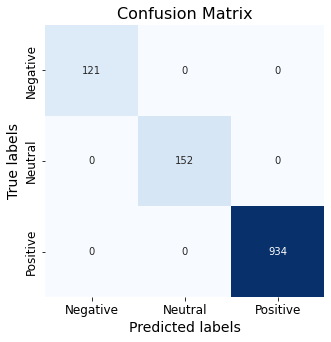

In [36]:

# Get the confusion matrix
cm = confusion_matrix(preprocessed_tweets_df['Sentiment'], predicted_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', cbar=False, ax=ax)

# Set the tick labels for the x-axis and y-axis
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=12)
ax.set_yticklabels(['Negative', 'Neutral', 'Positive'], fontsize=12)

# Set the axis labels
ax.set_xlabel("Predicted labels", fontsize=14)
ax.set_ylabel("True labels", fontsize=14)

# Set the title
ax.set_title("Confusion Matrix", fontsize=16)

plt.show()



 generates a confusion matrix plot using the 
confusion_matrix
 function from the scikit-learn library and the 
heatmap
 function from the seaborn library. It takes in the true labels from 
preprocessed_tweets_df['Sentiment']
 and the predicted labels from 
predicted_labels
. The confusion matrix is displayed as a heatmap with annotations for each cell value, where the x-axis corresponds to the predicted labels and the y-axis corresponds to the true labels. The tick labels for both axes are set to 
['Negative', 'Neutral', 'Positive']
, and the axis labels are set to "Predicted labels" and "True labels", respectively. Finally, the title of the plot is set to "Confusion Matrix".

# **In conclusion, based on these results, the Random Forest model appears to be a better choice for this specific problem.**